# MovieLens dataset alterations

The code provided in this notebook aims to alter the popular MovieLens dataset to account for a more diverse set of environments to test recommendation systems in. This includes :
-    An **Enriched** dataset, which is derived from the `movies.csv` data, enriched with some light data cleanup tasks and extended with data gathered by an IMDb crawler. The dataset also includes pre-processed movie tags, from the `tags.csv` file.
-   A **Reduced interactions dataset**, which holds out data from the `ratings.csv` file in order to simulate a situation where user interaction data is sparse.
-   There is also a **Mixed interactions dataset**, which does similarly to the Reduced interactions dataset, except it provides a more realistic mix of users with sufficient interaction data along with users with the reduced interaction count.


The purpose of these modified datasets is mainly to be used for the paper I'm working on: "Evaluation of data-driven recommender systems". However, it also serves as a starting point for other research as well.

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
DATASET_DIR = "/gdrive/MyDrive/movielens_small/ml-latest-small/"
def get_dataset_path(filename: str) -> str:
    return DATASET_DIR + filename

# Load and import

In [ ]:
import pandas as pd
import random
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [ ]:
movie_ratings = pd.read_csv(get_dataset_path("ratings.csv"))
# movie_ratings = movie_ratings.head(100000)
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
len(movie_ratings)

100836

In [ ]:
movie_data = pd.read_csv(get_dataset_path("movies.csv"))
# movie_date = movie_data.head(1000)
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
USER_COLUMN_NAME = 'userId'
CONTENT_COLUMN_NAME = 'movieId'
RATING_COLUMN_NAME = 'rating'

In [ ]:
movie_tags = pd.read_csv(get_dataset_path("tags.csv"))
movie_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
user_interactions_count_df = movie_ratings.groupby(['userId', 'movieId']).size().groupby(['userId']).size()

checking if there are any users with less than 5 interactions

In [ ]:
user_interactions_count_df.count()

610

In [ ]:
users_with_enough_interactions = user_interactions_count_df[user_interactions_count_df >= 5].reset_index()[[USER_COLUMN_NAME]]
# users_with_enough_interactions = users_with_enough_interactions.sample(100, random_state = 5)

In [ ]:
len(users_with_enough_interactions)

610

In [ ]:
movie_ratings = movie_ratings.merge(users_with_enough_interactions,
                    how='inner',
                    left_on=USER_COLUMN_NAME,
                    right_on=USER_COLUMN_NAME
                    )


In [ ]:
len(movie_ratings)

100836

# IMDb crawler

In [ ]:
!pip install cinemagoer > /dev/null

In [ ]:
import pandas as pd
from imdb import Cinemagoer, IMDbError

In [ ]:
imdb_api = Cinemagoer()

movie_data = pd.read_csv(get_dataset_path("movies.csv"))
movie_links = pd.read_csv(get_dataset_path("links.csv"))

movie_data = movie_data.merge(movie_links, on="movieId", how="left")
movie_ids = [ (movie[0], movie[1]) for movie in zip(movie_data['movieId'].tolist(), movie_data['imdbId'].tolist()) ]

In [ ]:
# TODO: replace ", " delimiter with something like "|"
def get_movie_imdb(imdb_id: int) -> tuple:
    """
    Fetch movie IMDb data.
    Parameters:
        imdb_id(int): id that corresponds to IMDb database.
    Returns:
        tuple: of fetched values for movie: (imdb_id, cast, writers, producers, runtime, box_office, plot)

    """
    if imdb_id is None:
        return ()
    cast, runtime, box_office, plot, writers, producers = '', '', '', '', '', ''
    try:
        movie = imdb_api.get_movie(imdb_id)
        if 'cast' in movie.keys():
            cast = ', '.join([cast_m['name'] for cast_m in movie['cast'][:10] if 'name' in cast_m.keys()])
        if 'runtimes' in movie.keys():
            runtime = movie['runtimes'][0]
        if 'box office' in movie.keys():
            box_office = movie['box office']
            if 'Budget' in box_office.keys():
                box_office = box_office['Budget']
            else:
                box_office = ''
        if 'plot outline' in movie.keys():
            plot = movie['plot outline']
        if 'writer' in movie.keys():
            writers = ', '.join([writer['name'] for writer in movie['writer'][:10] if 'name' in writer.keys()])
        if 'producer' in movie.keys():
            producers = ', '.join([producer['name'] for producer in movie['producer'][:10] if 'name' in producer.keys()])
        # return f"Cast: {cast}; Writers: {writers}; Producers: {producers}; Runtime: {runtime}; Box Office budget: {box_office}; Plot outline: {plot};"
        # return '; '.join([cast, writers, producers, runtime, box_office, plot])
        return (imdb_id, cast, writers, producers, runtime, box_office, plot)
    except IMDbError:
        print(f"problem with movie {imdb_id}")
        return (imdb_id, cast, writers, producers, runtime, box_office, plot)


In [ ]:
SAVE_INTERVAL = 500
interval_counter = 0

def save_checkpoint(data: list):
    imdb_df = pd.DataFrame(data, columns=['movieId', 'imdbId',\
                                               'Cast', 'Writers', 'Producers',\
                                               'Runtime', 'Box Office Budget', 'Plot outline'])
    imdb_df.to_csv('imdb.csv')

All the entries are fetched preemptively from IMDb and persisted in a file `imdb.csv`.

In [ ]:
movies_processed = 0
result = []
total_movies = len(movie_ids)
for movie in movie_ids:
    movie_tuple = (movie[0],) + get_movie_imdb(movie[1])
    result.append(movie_tuple)
    movies_processed += 1
    if interval_counter >= SAVE_INTERVAL:
        save_checkpoint(result)
        interval_counter = 0
    else:
        interval_counter += 1
    print(f"{movies_processed} / {total_movies} processed.")

print()

save_checkpoint(result)

# Enriched dataset


Create an **Enriched** dataset with data fetched from IMDb. We use the previously fetched data from `imdb.csv`.

> A note on **handling missing values**: All kinds of missing values will use either `N/A` (for string values) or `0` (for number values). This is to prevent the need to handle NaN values in most use-cases. A common issue is that pandas will default NaN values to np.nan, which is a floating point zero value. This results in errors with libraries expecting textual data and receiving a floating point type.
*If you need to handle it differently*, then all columns follow the above convention and you can easily replace them.

In [ ]:
tags = movie_tags.groupby(CONTENT_COLUMN_NAME).agg({'tag': lambda x: list(x)})
movie_data = movie_data.merge(tags, on=CONTENT_COLUMN_NAME, how="left")
movie_data['tag'] = movie_data['tag'].apply(lambda x: "|".join(x) if isinstance(x, list) else "N/A")

In [ ]:
def lowercase_genres(genres: str) -> str:
    split = genres.split('|')
    lowercased = [item.lower() for item in split]
    return '|'.join(lowercased)

In [ ]:
movie_data['genres'] = movie_data['genres'].apply(lambda x: lowercase_genres(x))

In [ ]:
movie_data.loc[movie_data['genres']=='(no genres listed)', 'genres'] = 'N/A' # remove the no genres value since Content-based approaches might not benefit from this value
movie_data.head()

,movieId,title,genres,tag
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,pixar|pixar|fun
1,2,Jumanji (1995),adventure|children|fantasy,fantasy|magic board game|Robin Williams|game
2,3,Grumpier Old Men (1995),comedy|romance,moldy|old
3,4,Waiting to Exhale (1995),comedy|drama|romance,N/A
4,5,Father of the Bride Part II (1995),comedy,pregnancy|remake


In [ ]:
imdb_db = pd.read_csv(get_dataset_path("imdb.csv"), index_col="movieId")
imdb_db.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
imdb_db.head()

,imdbId,Cast,Writers,Producers,Runtime,Box Office Budget,Plot outline
movieId,,,,,,,
1,114709,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...","John Lasseter, Pete Docter, Andrew Stanton, Jo...","Bonnie Arnold, Ed Catmull, Ralph Guggenheim, S...",81.0,"$30,000,000 (estimated)",A little boy named Andy loves to be in his roo...
2,113497,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...","Jonathan Hensleigh, Greg Taylor, Jim Strain, G...","Robert W. Cort, Ted Field, Larry Franco, Scott...",104.0,"$50,000,000 (estimated)","Jumanji, one of the most unique--and dangerous..."
3,113228,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...","Mark Steven Johnson, Mark Steven Johnson","Richard C. Berman, John Davis, George Folsey J...",101.0,"$25,000,000 (estimated)",Things don't seem to change much in Wabasha Co...
4,114885,"Whitney Houston, Angela Bassett, Loretta Devin...","Terry McMillan, Terry McMillan, Ron Bass","Ron Bass, Caron K, Terry McMillan, Deborah Sch...",124.0,"$16,000,000 (estimated)",This story based on the best selling novel by ...
5,113041,"Steve Martin, Diane Keaton, Martin Short, Kimb...","Albert Hackett, Frances Goodrich, Nancy Meyers...","Carol Baum, Bruce A. Block, Julie B. Crane, Ji...",106.0,"$30,000,000 (estimated)","In this sequel to ""Father of the Bride"", Georg..."


fill NaN values

In [ ]:
imdb_db['Cast'].fillna("N/A", inplace=True)
imdb_db['Producers'].fillna("N/A", inplace=True)
imdb_db['Writers'].fillna("N/A", inplace=True)
imdb_db['Producers'].fillna("N/A", inplace=True)
imdb_db['Runtime'].fillna(0, inplace=True)
imdb_db['Plot outline'].fillna("N/A", inplace=True)

replace delimiter
> NOTE: temporary until I rebuild IMdB dataset with better delimiter

In [ ]:
imdb_db['Cast'] = imdb_db['Cast'].apply(lambda x: "|".join(x.split(", ")))
imdb_db['Writers'] = imdb_db['Writers'].apply(lambda x: "|".join(x.split(", ")))
imdb_db['Producers'] = imdb_db['Producers'].apply(lambda x: "|".join(x.split(", ")))
imdb_db.head()

,imdbId,Cast,Writers,Producers,Runtime,Box Office Budget,Plot outline
movieId,,,,,,,
1,114709,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter|Pete Docter|Andrew Stanton|Joe R...,Bonnie Arnold|Ed Catmull|Ralph Guggenheim|Stev...,81.0,"$30,000,000 (estimated)",A little boy named Andy loves to be in his roo...
2,113497,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh|Greg Taylor|Jim Strain|Greg...,Robert W. Cort|Ted Field|Larry Franco|Scott Kr...,104.0,"$50,000,000 (estimated)","Jumanji, one of the most unique--and dangerous..."
3,113228,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson|Mark Steven Johnson,Richard C. Berman|John Davis|George Folsey Jr....,101.0,"$25,000,000 (estimated)",Things don't seem to change much in Wabasha Co...
4,114885,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan|Terry McMillan|Ron Bass,Ron Bass|Caron K|Terry McMillan|Deborah Schind...,124.0,"$16,000,000 (estimated)",This story based on the best selling novel by ...
5,113041,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett|Frances Goodrich|Nancy Meyers|C...,Carol Baum|Bruce A. Block|Julie B. Crane|Jim C...,106.0,"$30,000,000 (estimated)","In this sequel to ""Father of the Bride"", Georg..."


> TODO: might be unnecessary once I change imdb script

In [ ]:
def standardize_column_name(column: str) -> str:
    split = column.split(" ")
    camelcased = [ x[:1].upper()+x[1:] if idx != 0 else x[:1].lower() + x[1:] for idx, x in enumerate(split)]
    return "".join(camelcased)

In [ ]:
imdb_db.rename(lambda x: standardize_column_name(x), axis='columns', inplace=True)
imdb_db.head()

,imdbId,cast,writers,producers,runtime,boxOfficeBudget,plotOutline
movieId,,,,,,,
1,114709,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter|Pete Docter|Andrew Stanton|Joe R...,Bonnie Arnold|Ed Catmull|Ralph Guggenheim|Stev...,81.0,"$30,000,000 (estimated)",A little boy named Andy loves to be in his roo...
2,113497,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh|Greg Taylor|Jim Strain|Greg...,Robert W. Cort|Ted Field|Larry Franco|Scott Kr...,104.0,"$50,000,000 (estimated)","Jumanji, one of the most unique--and dangerous..."
3,113228,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson|Mark Steven Johnson,Richard C. Berman|John Davis|George Folsey Jr....,101.0,"$25,000,000 (estimated)",Things don't seem to change much in Wabasha Co...
4,114885,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan|Terry McMillan|Ron Bass,Ron Bass|Caron K|Terry McMillan|Deborah Schind...,124.0,"$16,000,000 (estimated)",This story based on the best selling novel by ...
5,113041,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett|Frances Goodrich|Nancy Meyers|C...,Carol Baum|Bruce A. Block|Julie B. Crane|Jim C...,106.0,"$30,000,000 (estimated)","In this sequel to ""Father of the Bride"", Georg..."


In [ ]:
# imdb_db['cast'] = imdb_db['cast'].apply(lambda x: str(x).split(", "))
# imdb_db['writers'] = imdb_db['writers'].apply(lambda x: str(x).split(", "))
# imdb_db['producers'] = imdb_db['producers'].apply(lambda x: str(x).split(", "))
imdb_db['runtime'] = imdb_db['runtime'].apply(float)
imdb_db['plotOutline'] = imdb_db['plotOutline'].apply(str)
imdb_db.head()


,imdbId,cast,writers,producers,runtime,boxOfficeBudget,plotOutline
movieId,,,,,,,
1,114709,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter|Pete Docter|Andrew Stanton|Joe R...,Bonnie Arnold|Ed Catmull|Ralph Guggenheim|Stev...,81.0,"$30,000,000 (estimated)",A little boy named Andy loves to be in his roo...
2,113497,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh|Greg Taylor|Jim Strain|Greg...,Robert W. Cort|Ted Field|Larry Franco|Scott Kr...,104.0,"$50,000,000 (estimated)","Jumanji, one of the most unique--and dangerous..."
3,113228,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson|Mark Steven Johnson,Richard C. Berman|John Davis|George Folsey Jr....,101.0,"$25,000,000 (estimated)",Things don't seem to change much in Wabasha Co...
4,114885,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan|Terry McMillan|Ron Bass,Ron Bass|Caron K|Terry McMillan|Deborah Schind...,124.0,"$16,000,000 (estimated)",This story based on the best selling novel by ...
5,113041,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett|Frances Goodrich|Nancy Meyers|C...,Carol Baum|Bruce A. Block|Julie B. Crane|Jim C...,106.0,"$30,000,000 (estimated)","In this sequel to ""Father of the Bride"", Georg..."


parse box office column

In [ ]:
import re
pattern = re.compile("(\d+,)+\d+") # Matches a comma-separated list of numbers \
 #(one or more digits followed by a comma, repeated, then ending with digits)
def parse_box_office(column) -> float:
    if column is None or type(column) == float:
        return 0.0
    matched = pattern.search(column)
    if matched is None:
        return 0.0
    amount = column[matched.start():matched.end()]
    num = re.sub(",", "", amount)
    return float(num)

In [ ]:
imdb_db['boxOfficeBudget'] = imdb_db['boxOfficeBudget'].apply(lambda x: parse_box_office(x))
imdb_db.head()

,imdbId,cast,writers,producers,runtime,boxOfficeBudget,plotOutline
movieId,,,,,,,
1,114709,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter|Pete Docter|Andrew Stanton|Joe R...,Bonnie Arnold|Ed Catmull|Ralph Guggenheim|Stev...,81.0,30000000.0,A little boy named Andy loves to be in his roo...
2,113497,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh|Greg Taylor|Jim Strain|Greg...,Robert W. Cort|Ted Field|Larry Franco|Scott Kr...,104.0,50000000.0,"Jumanji, one of the most unique--and dangerous..."
3,113228,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson|Mark Steven Johnson,Richard C. Berman|John Davis|George Folsey Jr....,101.0,25000000.0,Things don't seem to change much in Wabasha Co...
4,114885,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan|Terry McMillan|Ron Bass,Ron Bass|Caron K|Terry McMillan|Deborah Schind...,124.0,16000000.0,This story based on the best selling novel by ...
5,113041,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett|Frances Goodrich|Nancy Meyers|C...,Carol Baum|Bruce A. Block|Julie B. Crane|Jim C...,106.0,30000000.0,"In this sequel to ""Father of the Bride"", Georg..."


In [ ]:
enriched_df = movie_data.merge(right=imdb_db, on='movieId', how='left').set_index('movieId')
enriched_df.head()

,title,genres,tag,imdbId,cast,writers,producers,runtime,boxOfficeBudget,plotOutline
movieId,,,,,,,,,,
1,Toy Story (1995),adventure|animation|children|comedy|fantasy,pixar|pixar|fun,114709,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter|Pete Docter|Andrew Stanton|Joe R...,Bonnie Arnold|Ed Catmull|Ralph Guggenheim|Stev...,81.0,30000000.0,A little boy named Andy loves to be in his roo...
2,Jumanji (1995),adventure|children|fantasy,fantasy|magic board game|Robin Williams|game,113497,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh|Greg Taylor|Jim Strain|Greg...,Robert W. Cort|Ted Field|Larry Franco|Scott Kr...,104.0,50000000.0,"Jumanji, one of the most unique--and dangerous..."
3,Grumpier Old Men (1995),comedy|romance,moldy|old,113228,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson|Mark Steven Johnson,Richard C. Berman|John Davis|George Folsey Jr....,101.0,25000000.0,Things don't seem to change much in Wabasha Co...
4,Waiting to Exhale (1995),comedy|drama|romance,N/A,114885,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan|Terry McMillan|Ron Bass,Ron Bass|Caron K|Terry McMillan|Deborah Schind...,124.0,16000000.0,This story based on the best selling novel by ...
5,Father of the Bride Part II (1995),comedy,pregnancy|remake,113041,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett|Frances Goodrich|Nancy Meyers|C...,Carol Baum|Bruce A. Block|Julie B. Crane|Jim C...,106.0,30000000.0,"In this sequel to ""Father of the Bride"", Georg..."


In [ ]:
title_pattern = re.compile("\(\d+\)$") # matches exactly four numbers\
 # enclosed in brackets, right before the end of the string

def parse_year(column) -> int:
    matched = title_pattern.search(column)
    if matched is None:
        return 0
    year = column[matched.start()+1 : matched.end()-1]
    return int(year)

def remove_year(column) -> str:
    matched = title_pattern.search(column)
    if matched is None:
        return str(column)
    removed = str(column)[0: matched.start()] + str(column)[matched.end():]
    return removed.strip()

In [ ]:
enriched_df['year'] = enriched_df['title'].apply(lambda x: parse_year(x))
enriched_df['title'] = enriched_df['title'].apply(lambda x: remove_year(x))
enriched_df.head()

,title,genres,tag,imdbId,cast,writers,producers,runtime,boxOfficeBudget,plotOutline,year
movieId,,,,,,,,,,,
1,Toy Story,adventure|animation|children|comedy|fantasy,pixar|pixar|fun,114709,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter|Pete Docter|Andrew Stanton|Joe R...,Bonnie Arnold|Ed Catmull|Ralph Guggenheim|Stev...,81.0,30000000.0,A little boy named Andy loves to be in his roo...,1995
2,Jumanji,adventure|children|fantasy,fantasy|magic board game|Robin Williams|game,113497,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh|Greg Taylor|Jim Strain|Greg...,Robert W. Cort|Ted Field|Larry Franco|Scott Kr...,104.0,50000000.0,"Jumanji, one of the most unique--and dangerous...",1995
3,Grumpier Old Men,comedy|romance,moldy|old,113228,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson|Mark Steven Johnson,Richard C. Berman|John Davis|George Folsey Jr....,101.0,25000000.0,Things don't seem to change much in Wabasha Co...,1995
4,Waiting to Exhale,comedy|drama|romance,N/A,114885,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan|Terry McMillan|Ron Bass,Ron Bass|Caron K|Terry McMillan|Deborah Schind...,124.0,16000000.0,This story based on the best selling novel by ...,1995
5,Father of the Bride Part II,comedy,pregnancy|remake,113041,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett|Frances Goodrich|Nancy Meyers|C...,Carol Baum|Bruce A. Block|Julie B. Crane|Jim C...,106.0,30000000.0,"In this sequel to ""Father of the Bride"", Georg...",1995


In [ ]:
enriched_df.to_csv(get_dataset_path("enriched.csv"))

# Reduced interactions dataset

The *chronologically oldest* n interactions are kept in the dataset, while the *latest* (count - n ) are held out. n is represented by the `REDUCED_INTERACTION_COUNT` constant.

In [ ]:
REDUCED_INTERACTION_COUNT = 3

In [ ]:
movie_ratings = pd.read_csv(get_dataset_path("ratings.csv"))

In [ ]:
interactions_train_df = movie_ratings.sort_values('timestamp', inplace=False).groupby('userId').head(REDUCED_INTERACTION_COUNT) # oldest n
interactions_test_df = movie_ratings.sort_values('timestamp', inplace=False).groupby('userId').tail(-REDUCED_INTERACTION_COUNT) # latest n

In [ ]:
interactions_train_df.set_index("userId").to_csv(get_dataset_path("reduced_interactions.csv"))
interactions_test_df.set_index("userId").to_csv(get_dataset_path("reduced_interactions_heldout.csv"))

# Mixed interactions dataset

This approach simulates a mix of users with "enough" interactions with users with a reduced number of interactions, in order to represent a more real-world test case. The users with enough interactions have data held-out with stratification, while the reduced users use the same strategy used in the reduced dataset.

In [ ]:
from sklearn.model_selection import train_test_split

 The ratio constant represents the fraction of **reduced** users in terms of the total amount of users in the dataset.

In [ ]:
MIXED_INTERACTION_RATIO = 0.5
NORMAL_TEST_SIZE = 0.3

In [ ]:
users = movie_ratings['userId'].unique()
user_count = len(users)
reduced_users = users[:int(MIXED_INTERACTION_RATIO * user_count)]
normal_users = users[int(MIXED_INTERACTION_RATIO * user_count):]

In [ ]:
reduced_half = movie_ratings[movie_ratings['userId'].isin(reduced_users)]

In [ ]:
reduced_half.sort_values('timestamp', inplace=True)
reduced_half_train = reduced_half.groupby('userId', group_keys=False).head(REDUCED_INTERACTION_COUNT)
reduced_half_test = reduced_half.groupby('userId', group_keys=False).tail(-REDUCED_INTERACTION_COUNT)

In [ ]:
normal_half = movie_ratings[movie_ratings['userId'].isin(normal_users)]

In [ ]:
from math import ceil, floor
normal_half.sort_values('timestamp', inplace=True)
normal_half_train = normal_half.groupby('userId', group_keys=False).apply(lambda x: x.head(ceil((1-NORMAL_TEST_SIZE)*len(x))))
normal_half_test = normal_half.groupby('userId', group_keys=False).apply(lambda x: x.tail(floor(NORMAL_TEST_SIZE*len(x))))

In [ ]:
combined_train = pd.concat([reduced_half_train, normal_half_train], axis=0)
combined_train = combined_train.sample(frac=1) # shuffle items


combined_test = pd.concat([reduced_half_test, normal_half_test], axis=0)
combined_test = combined_test.sample(frac=1) # shuffle items

In [ ]:
combined_train.set_index("userId").to_csv(get_dataset_path("mixed_interactions.csv"))
combined_test.set_index("userId").to_csv(get_dataset_path("mixed_interactions_heldout.csv"))

# statistics

In [ ]:
import pandas as pd
movie_ratings = pd.read_csv(get_dataset_path("ratings.csv"))

In [ ]:
import matplotlib.pyplot as plt



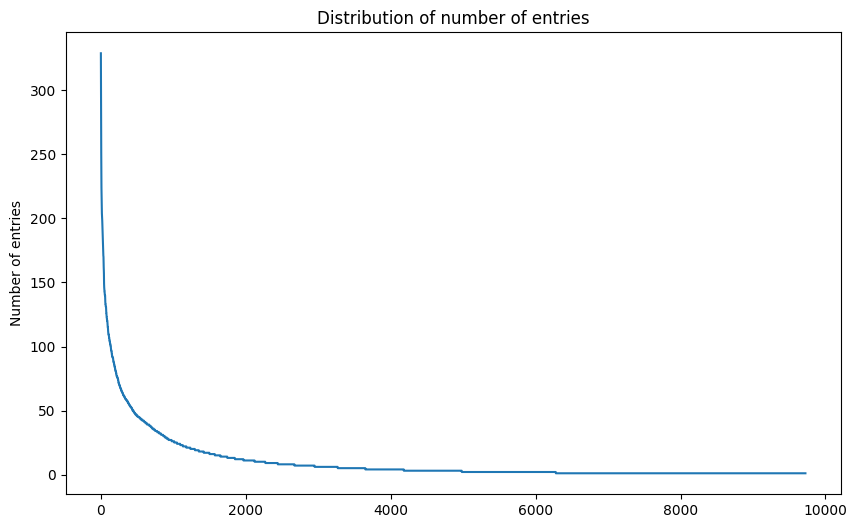

In [ ]:
movie_counts = movie_ratings['movieId'].value_counts()

# Create a histogram of the counts
plt.figure(figsize=(10, 6))
plt.plot(movie_counts.tolist())
plt.ylabel('Number of entries')
plt.title('Distribution of number of entries')
plt.show()